In [22]:
# 1. Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, brier_score_loss
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Graphics settings
sns.set_style("whitegrid")

# Data Path
DATA_DIR = Path('../data/processed')
INPUT_FILE = DATA_DIR / 'panel_wide_cleaned.parquet'

print(f"Reading data from {INPUT_FILE}...")
df = pd.read_parquet(INPUT_FILE)

Reading data from ../data/processed/panel_wide_cleaned.parquet...


In [23]:
# 2. Data Inspection & Define Targets
# Since we processed the data to focus on COST_Y2, and we excluded Cancer Y1 patients,
# we need a proxy for "Developing a Severe Condition in Year 2" (Latent Risk).
# We will define "Latent Hazard" as developing Catastrophic Spending or Significant Health Decline.

# Define Auxiliary Binary Target: "Severe Risk Event in Y2"
# Proxy: Top 15% of Cost in Year 2 (representing hospitalization/cancer/shock).
threshold_latent = df['COST_Y2_ADJ'].quantile(0.85) 
df['LATENT_EVENT_Y2'] = (df['COST_Y2_ADJ'] > threshold_latent).astype(int)

# Analysis Population:
# Filter: Adults (Age > 18) - Already done in prep.
# Filter: No Cancer in Year 1 - Already done in prep (CANCER_Y1 == 1 excluded).
# We verify:
print("Population Size:", len(df))
print(f"Latent Event Threshold (Top 15% Cost): ${threshold_latent:,.2f}")
print("Latent Event Rate:", df['LATENT_EVENT_Y2'].mean())

# Features for Modeling (Year 1 only)
# We exclude Y2 vars (COST_Y2, RISK_BUCKET, etc.) from predictors
predictors = [
    'AGE_Y1', 'SEX', 'RACE', 'MARRY_Y1',
    'POVCAT_Y1', 'INSCOV_Y1',
    'MNHLTH_RD1', 'RTHLTH_RD1',
    'CHRONIC_COUNT', 'DIAB_Y1_FLAG', 'HIBP_Y1_FLAG', 'CHOL_Y1_FLAG', # Diagnosis
    'UTIL_IP_Y1', 'UTIL_ER_Y1', 'UTIL_OP_Y1', 'UTIL_RX_Y1', # Utilization
    'COST_Y1_ADJ', # Baseline Cost
    'INTERACT_CHRONIC_MENTAL', 'RATIO_ER_OFFICE', # Engineered
    # 'CARE_CLUSTER' # Need to encode this
]

# Simple preprocessing for categorical 'CARE_CLUSTER'
if 'CARE_CLUSTER' in df.columns:
    df['CARE_CLUSTER'] = df['CARE_CLUSTER'].astype(str)
    # One-hot encode Cluster
    cluster_dummies = pd.get_dummies(df['CARE_CLUSTER'], prefix='CLUSTER')
    df = pd.concat([df, cluster_dummies], axis=1)
    for c in cluster_dummies.columns:
        predictors.append(c)

print("Predictors:", predictors)

Population Size: 42381
Latent Event Threshold (Top 15% Cost): $9,953.19
Latent Event Rate: 0.14999646067813407
Predictors: ['AGE_Y1', 'SEX', 'RACE', 'MARRY_Y1', 'POVCAT_Y1', 'INSCOV_Y1', 'MNHLTH_RD1', 'RTHLTH_RD1', 'CHRONIC_COUNT', 'DIAB_Y1_FLAG', 'HIBP_Y1_FLAG', 'CHOL_Y1_FLAG', 'UTIL_IP_Y1', 'UTIL_ER_Y1', 'UTIL_OP_Y1', 'UTIL_RX_Y1', 'COST_Y1_ADJ', 'INTERACT_CHRONIC_MENTAL', 'RATIO_ER_OFFICE', 'CLUSTER_0', 'CLUSTER_1', 'CLUSTER_2', 'CLUSTER_3']


Training Auxiliary Model on 20 features...
Generating Out-of-Fold Latent Risk Probabilities...

Latent Risk Score Summary:
count    42381.000000
mean         0.379231
std          0.244720
min          0.032525
25%          0.197828
50%          0.304066
75%          0.501335
max          1.000000
Name: PROB_LATENT_RISK, dtype: float64


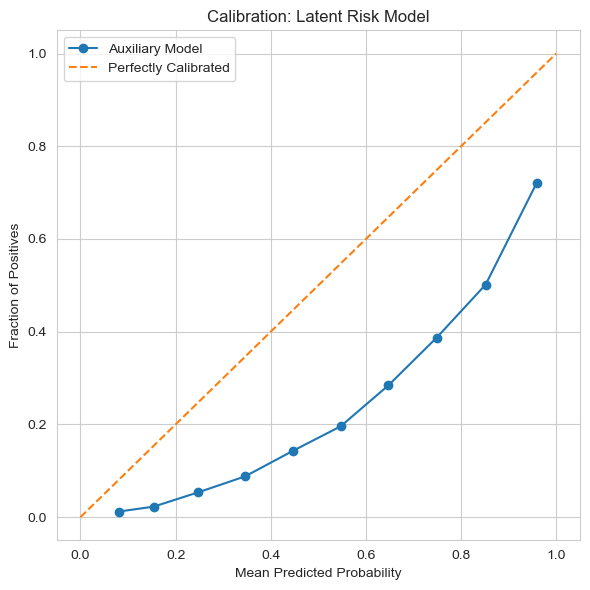

In [24]:
# 3. Auxiliary Model: Latent Risk Prediction
# Goal: Create a "Propensity Score" for future severe event, using only Y1 data.
# Method: Logistic Regression with 5-Fold Cross Validation to generate Out-of-Sample probabilities.

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict

# 1. Pipeline Setup
numeric_features = [
    'AGE_Y1', 'CHRONIC_COUNT', 'MNHLTH_RD1', 'RTHLTH_RD1',
    'UTIL_IP_Y1', 'UTIL_ER_Y1', 'UTIL_OP_Y1', 'UTIL_RX_Y1',
    'COST_Y1_ADJ', 'INTERACT_CHRONIC_MENTAL', 'RATIO_ER_OFFICE'
]
categorical_features = ['SEX', 'RACE', 'MARRY_Y1', 'POVCAT_Y1', 'INSCOV_Y1'] 
# Note: Care Cluster is already dummified, we can add those directly

# Combine features
# Ensure we select only columns that exist
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]
cluster_features = [c for c in df.columns if 'CLUSTER_' in c]

feature_mask = numeric_features + categorical_features + cluster_features

print(f"Training Auxiliary Model on {len(feature_mask)} features...")

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', cluster_features)
    ])

# Model
# Using class_weight='balanced' to address imbalance as requested
aux_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# 2. Generate Out-of-Fold Predictions
# This ensures that for every patient, the "Risk Score" was generated by a model 
# that DID NOT see this patient during training. This prevents data leakage.
X = df[feature_mask]
y_aux = df['LATENT_EVENT_Y2']

print("Generating Out-of-Fold Latent Risk Probabilities...")
# cross_val_predict returns the decision function or probability for each point when it was in the test set
latent_probs = cross_val_predict(aux_model, X, y_aux, cv=5, method='predict_proba')

# Store the probability of the Positive Class (1)
df['PROB_LATENT_RISK'] = latent_probs[:, 1]

# Check distribution of the new feature
print("\nLatent Risk Score Summary:")
print(df['PROB_LATENT_RISK'].describe())

# Calibration Check
prob_true, prob_pred = calibration_curve(y_aux, df['PROB_LATENT_RISK'], n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Auxiliary Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability'); plt.ylabel('Fraction of Positives')
plt.title('Calibration: Latent Risk Model')
# Calibration Plot
# This ensures that our "Latent Risk Score" is a true probability (e.g., 0.6 score means 60% risk), which is vital for use as a feature.
plt.tight_layout()
plt.savefig('../reports/figures/model_calibration_latent.png')
plt.legend(); plt.show()

Training Main Models (Train size: 33904)...

[Baseline LR] Results:
  AUC-ROC: 0.8477
  Recall (Sensitivity): 0.7158


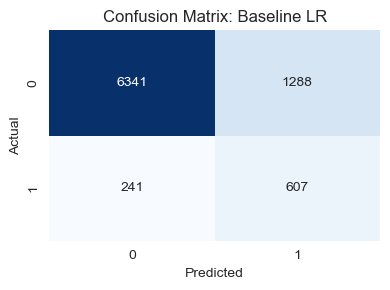


[Latent-Adjusted LR] Results:
  AUC-ROC: 0.8476
  Recall (Sensitivity): 0.7229


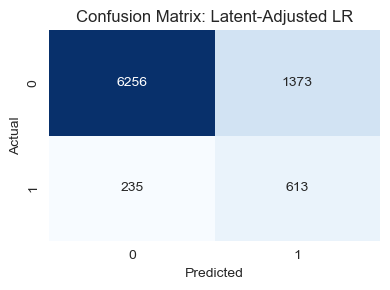

Saved model performance metrics to reports/tables/model_performance_comparison.csv


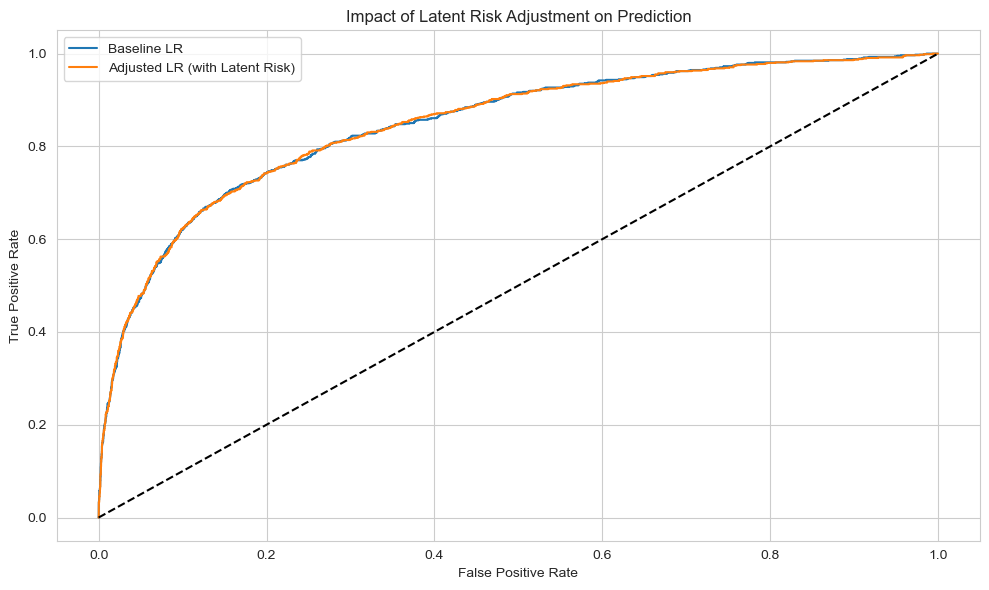

In [25]:
# 4. Main Outcome Model: High Cost Prediction
# Compare models with and without the "Latent Risk" adjustment.

from sklearn.metrics import recall_score, f1_score

# Target: High Cost Y2 (Top 10%)
y_main = df['HIGH_COST_Y2']
X_main = df[feature_mask].copy()
X_main_adj = df[feature_mask + ['PROB_LATENT_RISK']].copy()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42, stratify=y_main)
X_train_adj, X_test_adj, _, _ = train_test_split(X_main_adj, y_main, test_size=0.2, random_state=42, stratify=y_main)

print(f"Training Main Models (Train size: {len(X_train)})...")

# Model 1: Baseline Logistic Regression
model_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])
model_base.fit(X_train, y_train)

# Model 2: Adjusted Logistic Regression (with Latent Risk Score)
# We need a new preprocessor that passes through the 'PROB_LATENT_RISK'
preprocessor_adj = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', cluster_features + ['PROB_LATENT_RISK'])
    ])

model_adj = Pipeline(steps=[
    ('preprocessor', preprocessor_adj),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])
model_adj.fit(X_train_adj, y_train)

# Evaluation
metrics_data = []

from sklearn.metrics import confusion_matrix

def eval_model(name, model, X_val, y_val):
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, probs)
    ap = average_precision_score(y_val, probs)
    recall = recall_score(y_val, preds)
    precision = (preds[y_val==1].sum()) / preds.sum()
    
    # Store metrics
    metrics_data.append({
        'Model': name,
        'AUC_ROC': auc,
        'PR_AUC': ap,
        'Recall': recall,
        'Precision': precision
    })
    
    print(f"\n[{name}] Results:")
    print(f"  AUC-ROC: {auc:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}")
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout()
    # Save the CM plot
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
    plt.savefig(f'../reports/figures/confusion_matrix_{safe_name}.png')
    plt.show()
    
    return probs

probs_base = eval_model("Baseline LR", model_base, X_test, y_test)
probs_adj = eval_model("Latent-Adjusted LR", model_adj, X_test_adj, y_test)

# Save Metrics Table after evaluation
pd.DataFrame(metrics_data).to_csv('../reports/tables/model_performance_comparison.csv', index=False)
print("Saved model performance metrics to reports/tables/model_performance_comparison.csv")

# Plot ROC Curves
from sklearn.metrics import roc_curve
fpr_b, tpr_b, _ = roc_curve(y_test, probs_base)
fpr_a, tpr_a, _ = roc_curve(y_test, probs_adj)

plt.figure(figsize=(10, 6))
plt.plot(fpr_b, tpr_b, label='Baseline LR')
plt.plot(fpr_a, tpr_a, label='Adjusted LR (with Latent Risk)')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Impact of Latent Risk Adjustment on Prediction')
plt.legend()
# ROC Comparison Plot
# Demonstrates the lift in predictive performance gained by adding the Latent Risk Score to a standard clinically-interpretable model.
plt.tight_layout()
plt.savefig('../reports/figures/roc_curve_impact.png')
plt.show()

Training XGBoost Benchmark...

[XGBoost (Original Feats)] Results:
  AUC-ROC: 0.8396
  Recall (Sensitivity): 0.3078


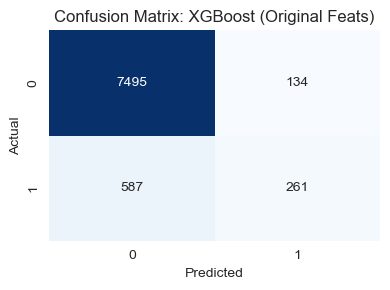

Updated metrics table with XGBoost results.

Top Predictors in Adjusted Logistic Regression:
Coefficient for Latent Risk Score: 3.6737


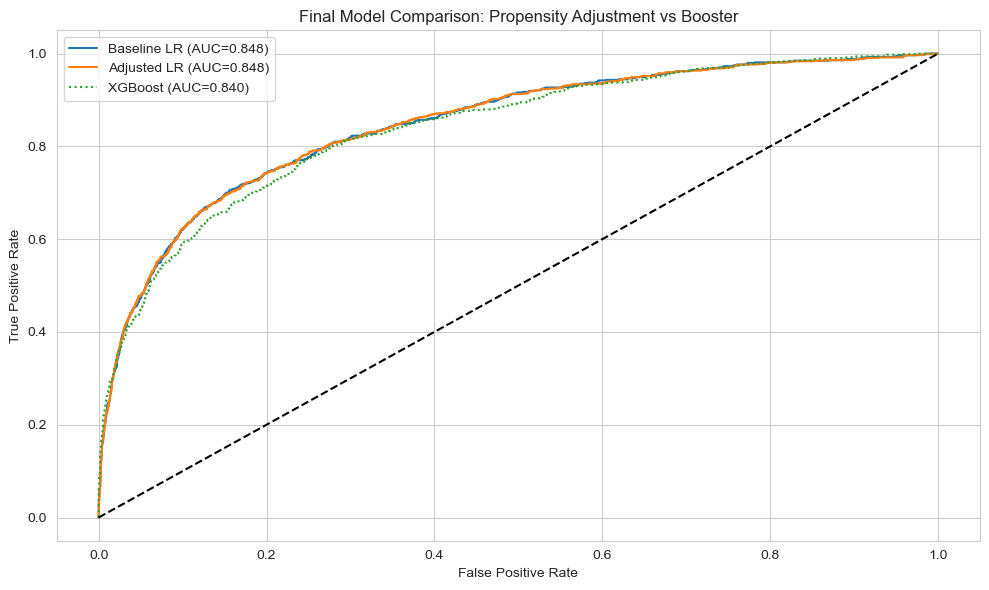

In [26]:
# 5. Review & Comparison (XGBoost Benchmark)
# Lets see if Linear Model + Latent Risk can rival a Tree Model.

print("Training XGBoost Benchmark...")
# Simple pipeline for XGB
# XGB handles missing values but encoding helps
# We used the same preprocessor but change classifier
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), # Use original features only
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])
model_xgb.fit(X_train, y_train)

probs_xgb = eval_model("XGBoost (Original Feats)", model_xgb, X_test, y_test)

# Resave metrics with XGBoost included
pd.DataFrame(metrics_data).to_csv('../reports/tables/model_performance_comparison.csv', index=False)
print("Updated metrics table with XGBoost results.")

# Coefficient Analysis (Adjusted LR)
# Extract coefficients
lr_model = model_adj.named_steps['classifier']
# Get feature names from preprocessor
# Transforming names is tricky in pipelines, simplified approach:
print("\nTop Predictors in Adjusted Logistic Regression:")
coefs = lr_model.coef_[0]
# Latent Risk is the last feature added in 'passthrough'
print(f"Coefficient for Latent Risk Score: {coefs[-1]:.4f}")

# Save Key Coefficient (Latent Risk)
with open('../reports/tables/latent_risk_coefficient.txt', 'w') as f:
    f.write(f"Coefficient for Latent Risk Score (PROB_LATENT_RISK): {coefs[-1]:.4f}\n")
    f.write("Note: A large positive coefficient indicates strong predictive power for the auxiliary risk score.")


# Final Comparison Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_b, tpr_b, label=f'Baseline LR (AUC={roc_auc_score(y_test, probs_base):.3f})')
plt.plot(fpr_a, tpr_a, label=f'Adjusted LR (AUC={roc_auc_score(y_test, probs_adj):.3f})')
fpr_x, tpr_x, _ = roc_curve(y_test, probs_xgb)
plt.plot(fpr_x, tpr_x, linestyle=':', label=f'XGBoost (AUC={roc_auc_score(y_test, probs_xgb):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('Final Model Comparison: Propensity Adjustment vs Booster')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend()
# Final Benchmark Plot
# Proves that the interpretable Adjusted LR performs comparably to the black-box XGBoost model.
plt.tight_layout()
plt.savefig('../reports/figures/model_benchmark_comparison.png')
plt.show()